# Descripción de la Notebook

<a id="titulo"></a>
- <a href="#imports"> Imports </a>
- <a href="#csv">Se lee el CSV de tracks tranformado. </a>
- <a href="#tratamiento_datos">Transformación de datos</a>
- <a href="#vars_obj">Se definen las clases para la variable objetivo</a>
- <a href="#analisis_datos">Análisis de datos</a>
- <a href="#entrenamiento">Se realiza el entrenamiento para los diferentes modelos</a>
    - <a href="#model_logistic_regression">Logistic Regression</a>
    - <a href="#model_bernoulli_naive_bayes">Bernoulli Naive Bayes</a>    
    - <a href="#model_knn">KNN</a>    
- <a href="#feature_selection">Se hace una reducción de features</a>
    - Se vuelve a probar los modelos con features reducidas
        - <a href="#feature_selection_logistic_regression">Logistic Regression</a>
        - <a href="#feature_selection_bernoulli_naive_bayes">Bernouille Naive Bayes</a>        
        - <a href="#feature_selection_knn">KNN</a>        
- <a href="#results">Se presentan resultados</a>

# Imports <a id="imports"></a>

<a href="#titulo">Volver al índice</a>

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
from sys import maxsize #para imprimir arrays completos
import numpy as np
import pandas as pd
import datetime
import time

from sklearn import preprocessing #para normalizar datos
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV #feature selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE #pip install -U imbalanced-learn

from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Para importar notebooks propias

In [3]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [4]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [5]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [6]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [7]:
sys.meta_path.append(NotebookFinder())

# Importamos bibliotecas propias

In [8]:
#luego de ejecutar las celdas anteriores, se puede importar la biblioteca propia
#si da errores, probar con hacer restart del kernel
import _3_Anexo_Func as funcs

importing Jupyter notebook from _3_Anexo_Func.ipynb


# Levantamos el CSV <a id="csv"></a>

<a href="#titulo">Volver al índice</a>

In [9]:
pathArchivoDataSet = 'tracks_clean.csv' 
df = pd.read_csv(pathArchivoDataSet)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29133 entries, 0 to 29132
Data columns (total 77 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          29133 non-null  int64  
 1   name                29133 non-null  object 
 2   album               29133 non-null  object 
 3   duration_ms         29133 non-null  int64  
 4   explicit            29133 non-null  int64  
 5   danceability        29133 non-null  float64
 6   energy              29133 non-null  float64
 7   loudness            29133 non-null  float64
 8   mode                29133 non-null  int64  
 9   speechiness         29133 non-null  float64
 10  acousticness        29133 non-null  float64
 11  instrumentalness    29133 non-null  float64
 12  liveness            29133 non-null  float64
 13  valence             29133 non-null  float64
 14  tempo               29133 non-null  float64
 15  artista_followers   29133 non-null  int64  
 16  arti

# Tratamiento de variables <a id="tratamiento_datos"></a>

<a href="#titulo">Volver al índice</a>

##### Codificamos la fecha de release_date a integer para poder hacer luego el balanceo de clases con SMOTE

In [11]:
df['release_date_int'] = df['release_date'].apply(lambda f: f.replace("-",""))

#### Generación de dummies para el dato 'escala'

In [12]:
df = pd.get_dummies(df, drop_first=True, columns=['escala'])

##### Transformamos la variable duration_ms en duration, que es en minutos

In [13]:
df['duration'] = df['duration_ms'] / 1000 / 60

In [14]:
#quitamos la duracion en ms
df = df.drop(labels=['duration_ms'], axis=1)

# Definimos las clases de la variable objetivo <a id="vars_obj"></a>

<a href="#titulo">Volver al índice</a>

probar reg logistic para tener mejor tiempo de ejecucion, NB**


In [15]:
def target_classes_generator(popularityValue):
    if(popularityValue < 30):
        return 0
    if(popularityValue >= 30 and popularityValue < 75):
        return 1
    if(popularityValue >= 75):
        return 2

##### Definimos un diccionario para tener labels para el código

In [16]:
target_classes_labels = {0: 'mala', 1: 'buena', 2: 'muy_buena' }

In [17]:
df['popularity_class'] = df['popularity'].apply(lambda p: target_classes_generator(p))

# Análisis de datos <a id="analisis_datos"></a>

<a href="#titulo">Volver al índice</a>

#### Gráfico de la distribución de los valores de popularidad

cambiar el tamaño de los means

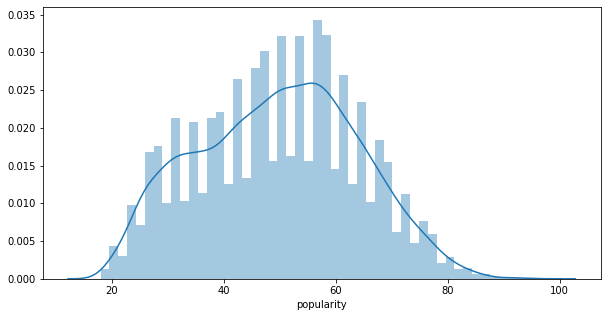

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df['popularity']);

#### Gráfico que muestra las cantidades de tracks para cada una de las clases objetivo definidas

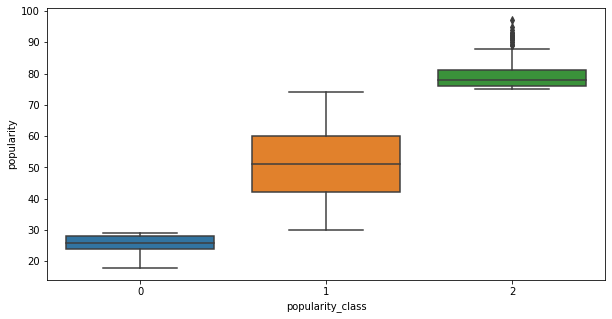

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='popularity_class', y='popularity', data=df)

# Entrenamiento de modelos <a id="entrenamiento"></a>

<a href="#titulo">Volver al índice</a>

In [20]:
training_cols = ['duration', 'explicit',
       'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'time_signature',
       'release_date_int', 'genre_ska', 'genre_flamenco', 'genre_metal',
       'genre_opera', 'genre_samba', 'genre_anime', 'genre_groove',
       'genre_indie', 'genre_bossa_nova', 'genre_trance', 'genre_rumba',
       'genre_gothic', 'genre_r&b', 'genre_under', 'genre_christian',
       'genre_folk', 'genre_reggae', 'genre_alternative', 'genre_rock',
       'genre_dubstep', 'genre_mambo', 'genre_dance', 'genre_country',
       'genre_funk', 'genre_reggaeton', 'genre_salsa', 'genre_swing',
       'genre_movie', 'genre_house', 'genre_freestyle', 'genre_instrumental',
       'genre_hip hop', 'genre_world', 'genre_blues', 'genre_neo',
       'genre_merengue', 'genre_disco', 'genre_punk', 'genre_bolero',
       'genre_jazz', 'genre_hardcore', 'genre_electronic', 'genre_trap',
       'genre_cumbia', 'genre_dub', 'genre_pop', 'genre_rave', 'genre_techno',
       'genre_ambient', 'genre_melodic', 'genre_progressive',
       'genre_experimental', 'genre_rap', 'genre_soul', 'genre_deep',
       'genre_tango', 'genre_others','escala_Do#', 'escala_Fa', 'escala_Fa#',
       'escala_La', 'escala_La#', 'escala_Mi', 'escala_Re', 'escala_Re#',
       'escala_Si', 'escala_Sol', 'escala_Sol#']

In [21]:
target_col = 'popularity_class'

In [22]:
X = df[training_cols]
y = df[target_col]

##### Vemos que las clases están desbalanceadas

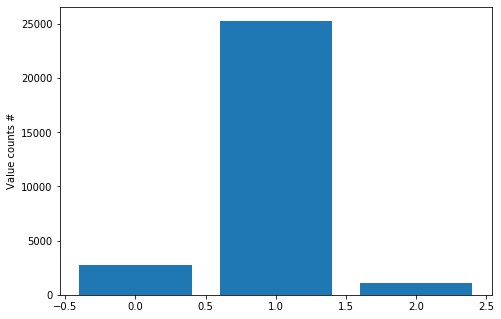

In [23]:
classes_status = pd.Series(y).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

##### Ya que la clase intermedia está sobre representada, eliminamos algunos registros para que el entrenamiento de los modelos no consuma muchos recursos

In [24]:
percent_to_delete = .6
df_simplified = df.drop(df[df['popularity_class'] == 1].sample(frac=percent_to_delete).index)

In [25]:
X = df_simplified[training_cols]
y = df_simplified[target_col]

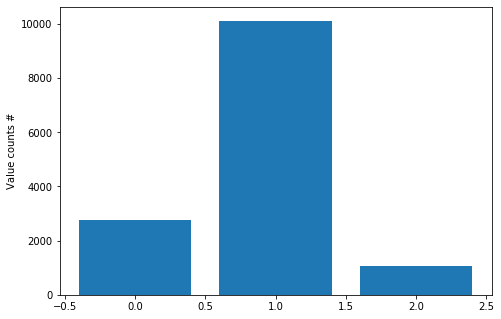

In [26]:
classes_status = pd.Series(y).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

##### Estandarizamos los features

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Oversampleamos las clases que tienen pocas ocurrencias

In [29]:
X_train_scaled_smoted, y_train_scaled_smoted  = SMOTE().fit_resample(X_train_scaled, y_train)

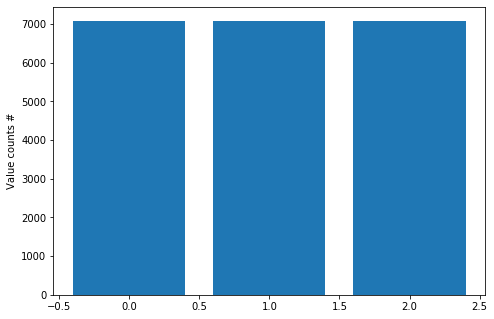

In [30]:
classes_status = pd.Series(y_train_scaled_smoted).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

## Logistic Regression  <a id="model_logistic_regression"></a>

<a href="#titulo">Volver al índice</a>

In [31]:
reg_log_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', linear_model.LogisticRegression())]

reg_log_pipe_grid=Pipeline(reg_log_pasos)

##### Definimos hiperparámetros para el modelo

In [32]:
reg_log_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler(), None],
                           'clasificador__C':np.linspace(0.0001, 5, 20), 
                           'clasificador__penalty':['l1', 'l2']}]

In [33]:
start_time = time.time()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
reg_log_grid=GridSearchCV(reg_log_pipe_grid, reg_log_new_param_grid, cv=kf)
reg_log_grid.fit(X_train_scaled_smoted, y_train_scaled_smoted)
print("--- %s seconds ---" % (time.time() - start_time))

--- 278.6791567802429 seconds ---


##### Vemos los resultados

In [34]:
reg_log_grid.best_params_

{'clasificador__C': 1.8421684210526315,
 'clasificador__penalty': 'l2',
 'preprocesamiento': MinMaxScaler()}

In [35]:
print('Regresión Logística score: ' + str(reg_log_grid.score(X_test_scaled, y_test)))

Regresión Logística score: 0.630673674151935


In [36]:
reg_log_predicciones = reg_log_grid.predict(X_test_scaled)

array([ 702,  122,    5,  685, 1691,  660,    4,   70,  247], dtype=int64)

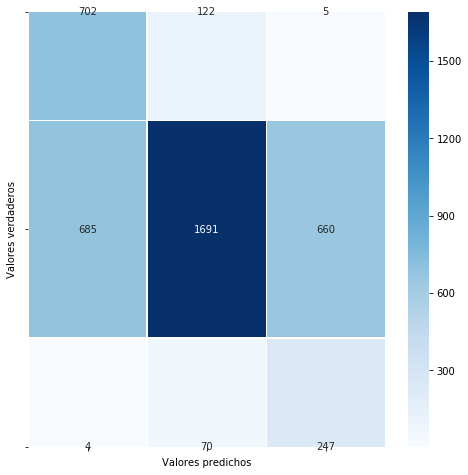

In [37]:
funcs.getConfusionMatrix(y_test, reg_log_predicciones, size = 8)

##### Aporte de cada uno de los coeficientes

In [38]:
lr_coeficientes = reg_log_grid.best_estimator_.steps[1][1].coef_

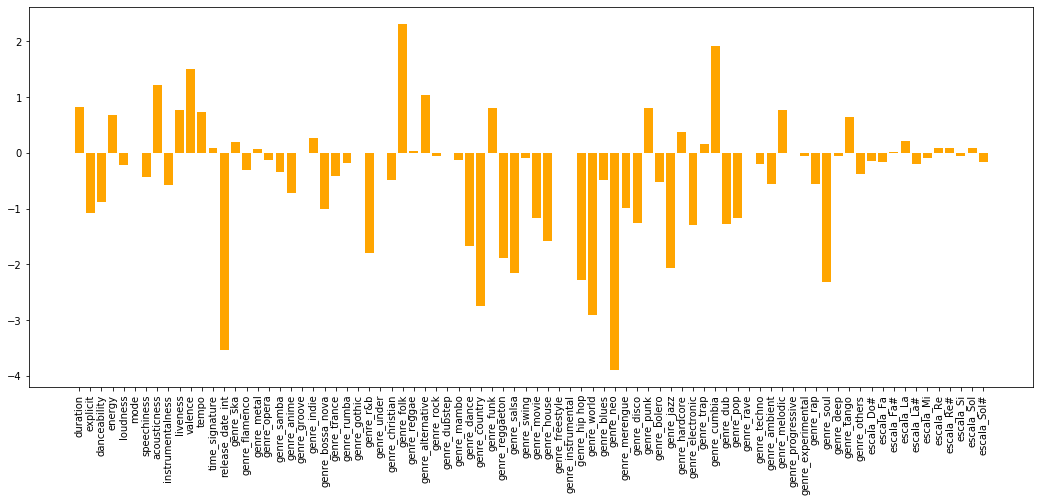

In [39]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[0])), X_train.columns, rotation=90)
plt.show()

## Bernoulli Naive Bayes  <a id="model_bernoulli_naive_bayes"></a>

<a href="#titulo">Volver al índice</a>

In [40]:
bnb_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', BernoulliNB())]

bnb_pipe_grid=Pipeline(bnb_pasos)

##### Definimos hiperparámetros para el modelo

In [41]:
bnb_new_param_grid = [{'preprocesamiento':[None, MinMaxScaler(), StandardScaler()],
                           'clasificador__alpha':np.linspace(0.0001, 10, 40)}]

In [42]:
start_time = time.time()
bnb_grid=GridSearchCV(bnb_pipe_grid, bnb_new_param_grid, cv=kf)
bnb_grid.fit(X_train_scaled_smoted,y_train_scaled_smoted)
print("--- %s seconds ---" % (time.time() - start_time))

--- 46.39523887634277 seconds ---


##### Vemos los resultados

In [43]:
bnb_grid.best_params_

{'clasificador__alpha': 0.0001, 'preprocesamiento': StandardScaler()}

In [44]:
print('Bernouilli Naive Bayes score: ' + str(bnb_grid.score(X_test_scaled, y_test)))

Bernouilli Naive Bayes score: 0.5864787386526517


In [45]:
bnb_predicciones = bnb_grid.predict(X_test_scaled)

array([ 693,  125,   11,  759, 1515,  762,    5,   69,  247], dtype=int64)

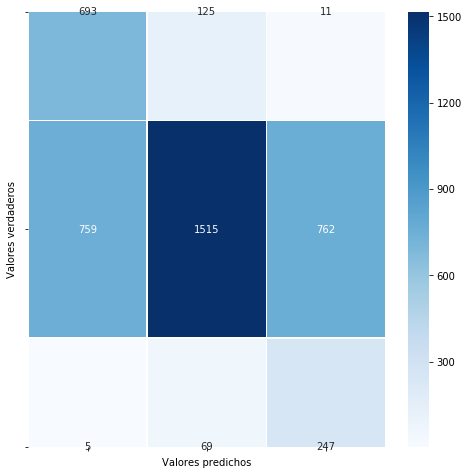

In [46]:
funcs.getConfusionMatrix(y_test, bnb_predicciones, size = 8)

## KNN  <a id="model_knn"></a>

<a href="#titulo">Volver al índice</a>

Kfold con stratify
probar con NB para ver el comportamiento
probar con K > 1
analizar las clases en el train set

In [47]:
start_time = time.time()
knn_scores = funcs.getScoresForHyperparameterK(quantityK=4, stepK= 1, model_X_train=X_train_scaled_smoted, \
                                               model_y_train=y_train_scaled_smoted, \
                                                kFold_N_Splits=5, KFold_shuffle=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 571.198893070221 seconds ---


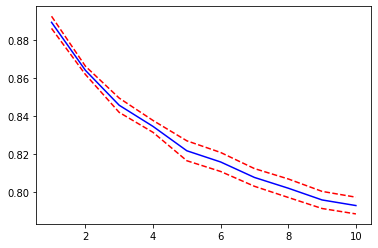

In [48]:
plt.plot(knn_scores['n_neighbours'],knn_scores['limite_inferior'],color='r', linestyle='--')
plt.plot(knn_scores['n_neighbours'],knn_scores['score_medio'],color='b')
plt.plot(knn_scores['n_neighbours'],knn_scores['limite_superior'],color='r', linestyle='--');

##### Mejor score

In [49]:
#quitamos el resultado para K = 1
knn_scores = knn_scores[knn_scores['n_neighbours'] > 1]
#tomamos el mejor score
knn_scores.loc[knn_scores.score_medio == knn_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
1,0.86422,0.002194,2,0.862027,0.866414


##### Seleccionamos uno

In [50]:
best_k = knn_scores.loc[knn_scores.score_medio == knn_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
print('Seleccionado K =', best_k)

Seleccionado K = 2


##### Obtenido el valor para K, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro K

In [51]:
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
start_time = time.time()
knn_y_pred, knn_pred_score = funcs.getKNNPredictions(X_train_scaled_smoted, y_train_scaled_smoted, X_test_scaled, y_test, best_k)
print("--- %s seconds ---" % (time.time() - start_time))

KNeighborsClassifier(n_neighbors=2)
--- 24.31849503517151 seconds ---


##### Score KNN para el testeo

In [52]:
knn_pred_score

0.6528905876731964

##### Analizamos los resultados en la matriz de confusión

array([ 658,  170,    1,  778, 1949,  309,    8,  187,  126], dtype=int64)

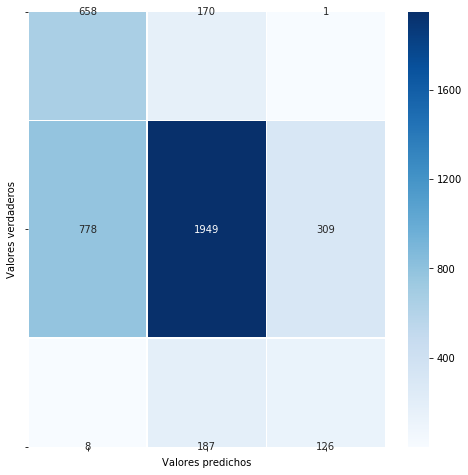

In [53]:
funcs.getConfusionMatrix(y_test, knn_y_pred, size= 8)

# Feature Selection <a id="feature_selection"></a>

<a href="#titulo">Volver al índice</a>

##### Definimos el feature selector

In [54]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
estimator = linear_model.LogisticRegression()
selector = RFECV(estimator, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)

##### Definimos un grid search, para optimizar el feature selector con el hiperparámetro C de la regresión logística

In [55]:
#grid_hiperparametros = {"estimator__C": np.linspace(0.0001, 5, 5)}
grid_hiperparametros = {"estimator__C": [1]}

In [56]:
start_time = time.time()
grid = RandomizedSearchCV(estimator=selector, param_distributions=grid_hiperparametros, cv=kf, random_state = 42)
grid.fit(X_train_scaled_smoted, y_train_scaled_smoted)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 fe

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.


Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 fe

Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 fe

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.


Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 featu

Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 fe

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.

Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 featu

##### Mejor estimador resultante para la selección de features

In [57]:
grid.best_estimator_

RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(C=1), scoring='neg_mean_squared_error',
      verbose=2)

##### El mejor hiperparámetro C seleccionado

In [58]:
grid.best_params_

{'estimator__C': 1}

##### Puntaje de la mejor selección

In [59]:
grid.best_score_

0.7656551399670666

### Analizamos cómo resultó el feature selection

In [60]:
print("Número óptimo de features : %d" % grid.best_estimator_.n_features_)

Número óptimo de features : 71


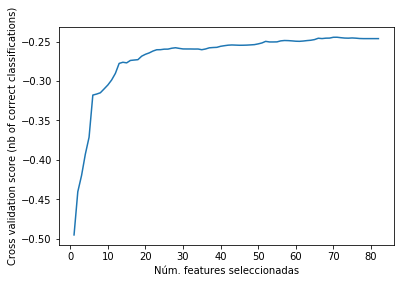

In [61]:
#Grafico que muestra el score del cross validation, dependiendo de la cantidad de features seleccionadas
plt.figure()
plt.xlabel("Núm. features seleccionadas")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(grid.best_estimator_.grid_scores_) + 1), grid.best_estimator_.grid_scores_)
plt.show()

In [62]:
X = df_simplified[X_train.columns[grid.best_estimator_.support_]]
y = df_simplified[target_col]

In [63]:
print("Número original de features : %d" % len(training_cols))
print("Número óptimo de features : %d" % len(X.columns))

Número original de features : 82
Número óptimo de features : 71


In [64]:
X_FS_train, X_FS_test, y_FS_train, y_FS_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=42)

In [65]:
scaler = StandardScaler()
X_FS_train_scaled = scaler.fit_transform(X_FS_train)
X_FS_test_scaled = scaler.transform(X_FS_test)

##### Oversampleamos las clases que tienen pocas ocurrencias

In [66]:
start_time = time.time()
X_FS_train_scaled_smoted, y_FS_train_scaled_smoted  = SMOTE().fit_resample(X_FS_train_scaled, y_FS_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.6919310092926025 seconds ---


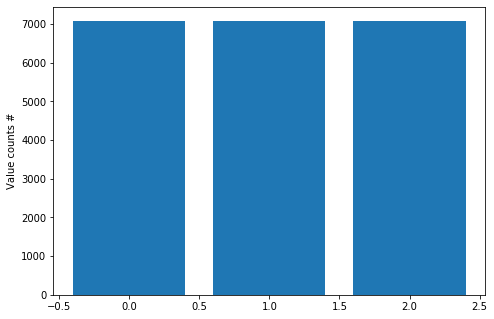

In [68]:
classes_status = pd.Series(y_FS_train_scaled_smoted).value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes_status.index,classes_status)
plt.ylabel('Value counts #')
plt.show()

## Feature Selection - Logistic Regression <a id="feature_selection_logistic_regression"></a>

<a href="#titulo">Volver al índice</a>

In [69]:
reg_log_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', linear_model.LogisticRegression())]

reg_log_pipe_grid=Pipeline(reg_log_pasos)

##### Definimos hiperparámetros para el modelo

In [70]:
reg_log_new_param_grid = [{'preprocesamiento':[MinMaxScaler(), StandardScaler(), None],
                           'clasificador__C':np.linspace(0.0001, 5, 20), 
                           'clasificador__penalty':['l1', 'l2']}]

In [71]:
start_time = time.time()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
reg_log_grid=GridSearchCV(reg_log_pipe_grid, reg_log_new_param_grid, cv=kf)
reg_log_grid.fit(X_FS_train_scaled_smoted, y_FS_train_scaled_smoted)
print("--- %s seconds ---" % (time.time() - start_time))

--- 275.7578649520874 seconds ---


##### Vemos los resultados

In [72]:
reg_log_grid.best_params_

{'clasificador__C': 0.5264052631578947,
 'clasificador__penalty': 'l2',
 'preprocesamiento': MinMaxScaler()}

In [73]:
print('Regresión Logística score: ' + str(reg_log_grid.score(X_FS_test_scaled, y_FS_test)))

Regresión Logística score: 0.6304347826086957


In [74]:
FS_reg_log_predicciones = reg_log_grid.predict(X_FS_test_scaled)

array([ 705,  119,    5,  688, 1682,  666,    3,   66,  252], dtype=int64)

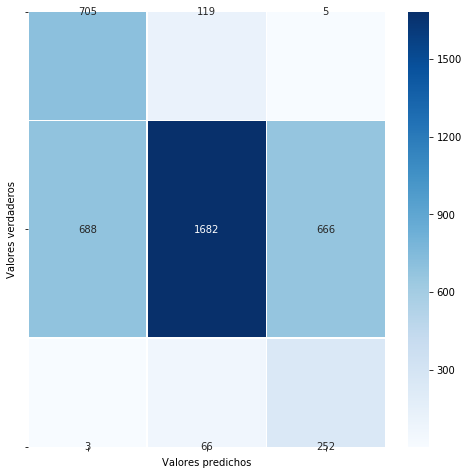

In [75]:
funcs.getConfusionMatrix(y_FS_test, FS_reg_log_predicciones, size = 8)

##### Aporte de cada uno de los coeficientes

In [76]:
lr_coeficientes = reg_log_grid.best_estimator_.steps[1][1].coef_

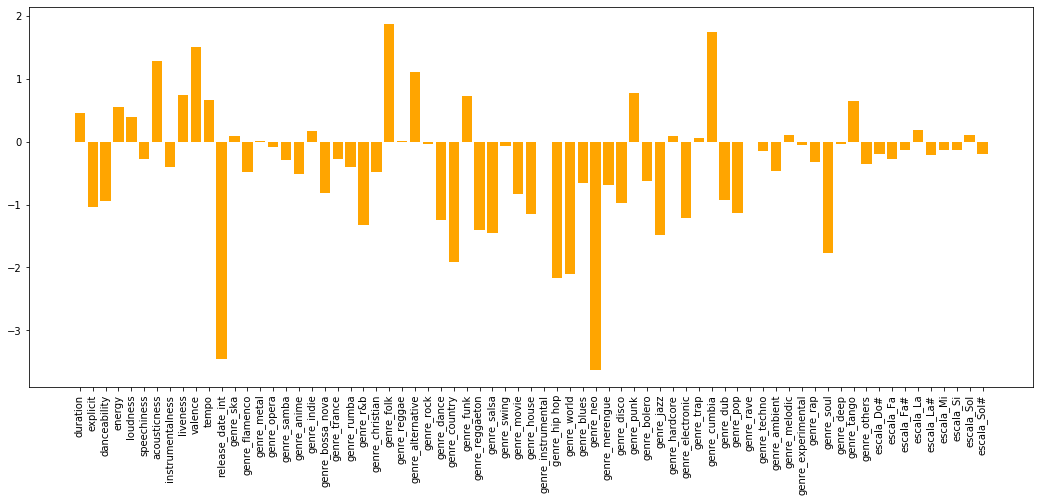

In [77]:
#graficamos el peso de cada uno de los coeficientes del modelo
fig, ax = plt.subplots(figsize=(18,7)) 
plt.bar([x for x in range(len(lr_coeficientes[0]))], lr_coeficientes[0],color='orange', linewidth=0.8)
plt.xticks(range(0,len(lr_coeficientes[0])), X_FS_train.columns, rotation=90)
plt.show()

## Bernoulli Naive Bayes  <a id="feature_selection_bernoulli_naive_bayes"></a>

<a href="#titulo">Volver al índice</a>

In [78]:
bnb_pasos = [('preprocesamiento', MinMaxScaler()), 
             ('clasificador', BernoulliNB())]

bnb_pipe_grid=Pipeline(bnb_pasos)

##### Definimos hiperparámetros para el modelo

In [79]:
bnb_new_param_grid = [{'preprocesamiento':[None, MinMaxScaler(), StandardScaler()],
                           'clasificador__alpha':np.linspace(0.0001, 10, 40)}]

In [80]:
start_time = time.time()
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
bnb_grid=GridSearchCV(bnb_pipe_grid, bnb_new_param_grid, cv=kf)
bnb_grid.fit(X_FS_train_scaled_smoted,y_FS_train_scaled_smoted)
print("--- %s seconds ---" % (time.time() - start_time))

--- 42.57935571670532 seconds ---


##### Vemos los resultados

In [81]:
bnb_grid.best_params_

{'clasificador__alpha': 0.0001, 'preprocesamiento': StandardScaler()}

In [82]:
print('Bernouilli Naive Bayes score: ' + str(bnb_grid.score(X_FS_test_scaled, y_FS_test)))

Bernouilli Naive Bayes score: 0.5809842331581462


In [83]:
FS_bnb_predicciones = bnb_grid.predict(X_FS_test_scaled)

array([ 689,  130,   10,  760, 1494,  782,    4,   68,  249], dtype=int64)

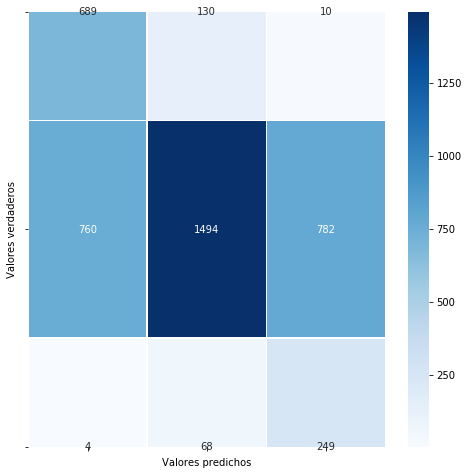

In [84]:
funcs.getConfusionMatrix(y_FS_test, FS_bnb_predicciones, size = 8)

## Feature Selection - KNN <a id="feature_selection_knn"></a>

<a href="#titulo">Volver al índice</a>

In [86]:
start_time = time.time()
FS_knn_scores = funcs.getScoresForHyperparameterK(quantityK=4, stepK= 1, model_X_train=X_FS_train_scaled_smoted, \
                                               model_y_train=y_FS_train_scaled_smoted, \
                                                kFold_N_Splits=5, KFold_shuffle=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 193.68931078910828 seconds ---


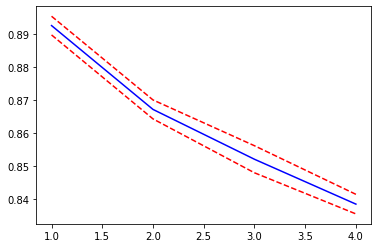

In [87]:
plt.plot(FS_knn_scores['n_neighbours'],FS_knn_scores['limite_inferior'],color='r', linestyle='--')
plt.plot(FS_knn_scores['n_neighbours'],FS_knn_scores['score_medio'],color='b')
plt.plot(FS_knn_scores['n_neighbours'],FS_knn_scores['limite_superior'],color='r', linestyle='--');

##### Mejor score

In [88]:
#quitamos el resultado para K = 1
FS_knn_scores = FS_knn_scores[FS_knn_scores['n_neighbours'] > 1]
FS_knn_scores.loc[FS_knn_scores.score_medio == FS_knn_scores.score_medio.max()]

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
1,0.86709,0.002873,2,0.864217,0.869963


##### Seleccionamos uno

In [89]:
best_k = FS_knn_scores.loc[FS_knn_scores.score_medio == FS_knn_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]
print('Seleccionado K =', best_k)

Seleccionado K = 2


##### Obtenido el valor para K, procedemos a ver como se comporta el modelo con datos no utilizados en la búsqueda del hiperparámetro K

In [90]:
start_time = time.time()
#obtenemos las predicciones del modelo, utilizando el mejor K obtenido
FS_knn_y_pred, FS_knn_pred_score = funcs.getKNNPredictions(X_FS_train_scaled_smoted, y_FS_train_scaled_smoted, 
                                                     X_FS_test_scaled, y_FS_test, best_k)
print("--- %s seconds ---" % (time.time() - start_time))

KNeighborsClassifier(n_neighbors=2)
--- 21.376972198486328 seconds ---


##### Score KNN para el testeo

In [91]:
FS_knn_pred_score

0.659818442427138

##### Analizamos los resultados en la matriz de confusión

array([ 660,  167,    2,  739, 1983,  314,   10,  192,  119], dtype=int64)

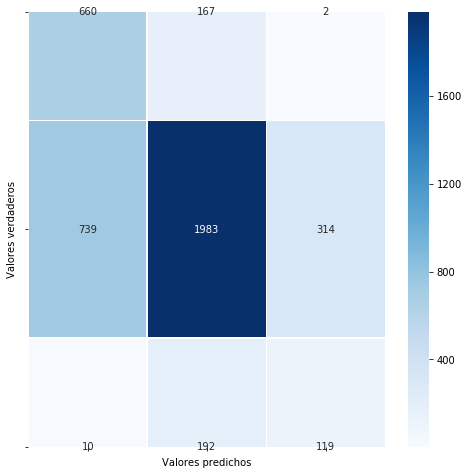

In [92]:
funcs.getConfusionMatrix(y_FS_test, FS_knn_y_pred, size= 8)

# Análisis de resultados <a id="results"></a>

<a href="#titulo">Volver al índice</a>

In [93]:
print('SIN FEATURE SELECTION: ')
print('-----------------------------------------------------------')
print('Regresion Logistica')
print(classification_report(y_FS_test,reg_log_predicciones))
print('-----------------------------------------------------------')
print('Bernoulli Naive Bayes')
print(classification_report(y_FS_test,bnb_predicciones))
print('-----------------------------------------------------------')
print('KNN')
print(classification_report(y_FS_test,knn_y_pred))

SIN FEATURE SELECTION: 
-----------------------------------------------------------
Regresion Logistica
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       829
           1       0.90      0.56      0.69      3036
           2       0.27      0.77      0.40       321

    accuracy                           0.63      4186
   macro avg       0.56      0.72      0.57      4186
weighted avg       0.77      0.63      0.65      4186

-----------------------------------------------------------
Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.48      0.84      0.61       829
           1       0.89      0.50      0.64      3036
           2       0.24      0.77      0.37       321

    accuracy                           0.59      4186
   macro avg       0.53      0.70      0.54      4186
weighted avg       0.76      0.59      0.61      4186

----------------------------------------------------

In [96]:
print('CON FEATURE SELECTION: ')
print('-----------------------------------------------------------')
print('Regresion Logistica')
print(classification_report(y_FS_test,FS_reg_log_predicciones))
print('-----------------------------------------------------------')
print('Bernoulli Naive Bayes')
print(classification_report(y_FS_test,FS_bnb_predicciones))
print('-----------------------------------------------------------')
print('KNN')
print(classification_report(y_FS_test,FS_knn_y_pred))

CON FEATURE SELECTION: 
-----------------------------------------------------------
Regresion Logistica
              precision    recall  f1-score   support

           0       0.51      0.85      0.63       829
           1       0.90      0.55      0.69      3036
           2       0.27      0.79      0.41       321

    accuracy                           0.63      4186
   macro avg       0.56      0.73      0.57      4186
weighted avg       0.77      0.63      0.65      4186

-----------------------------------------------------------
Bernoulli Naive Bayes
              precision    recall  f1-score   support

           0       0.47      0.83      0.60       829
           1       0.88      0.49      0.63      3036
           2       0.24      0.78      0.37       321

    accuracy                           0.58      4186
   macro avg       0.53      0.70      0.53      4186
weighted avg       0.75      0.58      0.61      4186

----------------------------------------------------

## Curvas ROC

In [97]:
#definimos un array de diccionarios para recopilar la info de todos los modelos para luego pasarla a la función que plotea
#la curva ROC
rocComparisonDictionary = []

#KNN
rocComparisonDictionary.append({"y_prob": knn_y_pred, "modelLabel": "KNN (K=2)"})
#regresion logistica
rocComparisonDictionary.append({"y_prob": reg_log_predicciones, "modelLabel": "Reg Logisitica"})
#Bernoulli Naive Bayes
rocComparisonDictionary.append({"y_prob": bnb_predicciones, "modelLabel": "Bernouilli NB"})

#Feature selection KNN
rocComparisonDictionary.append({"y_prob": FS_knn_y_pred, "modelLabel": "KNN (K=2)"})
#Feature selection regresion logistica
rocComparisonDictionary.append({"y_prob": FS_reg_log_predicciones, "modelLabel": "Reg Logisitica"})
#Feature selection Bernoulli Naive Bayes
rocComparisonDictionary.append({"y_prob": FS_bnb_predicciones, "modelLabel": "Bernouilli NB"})

ValueError: multiclass format is not supported

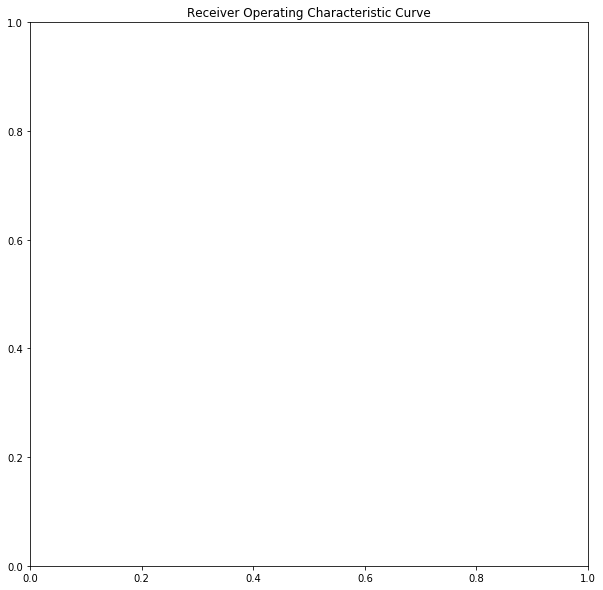

In [98]:
funcs.plotMultipleROC_Curve(y_test, rocComparisonDictionary)